In [1]:
from typing import Annotated, Literal

from langchain_community.tools import DuckDuckGoSearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_core.messages import BaseMessage, HumanMessage

from langchain_ollama import ChatOllama
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

In [2]:
search_tool = DuckDuckGoSearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [3]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. At a minimum use a search assistant to verify what you "
        " believe the answer should be. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [4]:
llm = ChatOllama(
    model="llama3.3",
    temperature=0,
    num_ctx=8192,
)

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[search_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague. Once the chart is made plot with matplotlib."
    ),
)


def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

In [5]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

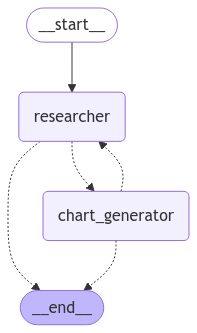

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

{'researcher': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='a2252239-2378-4e84-88a9-098e7b5940d1'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.3', 'created_at': '2025-02-14T14:50:45.76077Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5922087584, 'load_duration': 42780750, 'prompt_eval_count': 331, 'prompt_eval_duration': 4012000000, 'eval_count': 25, 'eval_duration': 1865000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-7a6cf918-347e-4696-9af2-8f85b3bf00a4-0', tool_calls=[{'name': 'duckduckgo_results_json', 'args': {'query': 'UK GDP past 5 years'}, 'id': '9bed196b-2324-4974-8394-3ca8f3b8c275', 'type': 'tool_call'}], usage_metadata={'input_tokens': 331, 'output_tokens': 25, 'total_tokens': 356}), ToolMessage(content='snippet: Time period All La

Python REPL can execute arbitrary code. Use with caution.


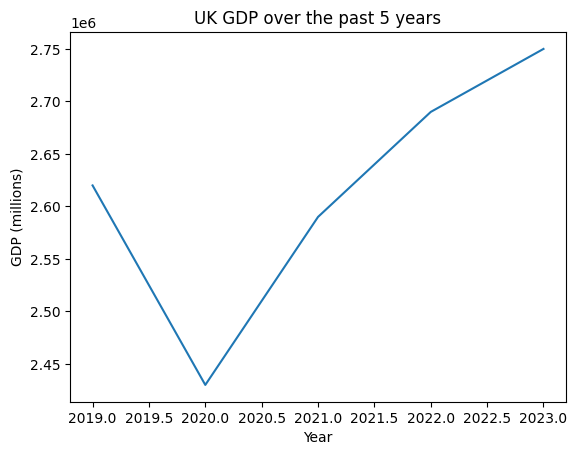

{'chart_generator': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='a2252239-2378-4e84-88a9-098e7b5940d1'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.3', 'created_at': '2025-02-14T14:50:45.76077Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5922087584, 'load_duration': 42780750, 'prompt_eval_count': 331, 'prompt_eval_duration': 4012000000, 'eval_count': 25, 'eval_duration': 1865000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-7a6cf918-347e-4696-9af2-8f85b3bf00a4-0', tool_calls=[{'name': 'duckduckgo_results_json', 'args': {'query': 'UK GDP past 5 years'}, 'id': '9bed196b-2324-4974-8394-3ca8f3b8c275', 'type': 'tool_call'}], usage_metadata={'input_tokens': 331, 'output_tokens': 25, 'total_tokens': 356}), ToolMessage(content='snippet: Time period A

In [7]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for event in events:
    print(event)
    for value in event.values():
        value["messages"][-1].pretty_print()
    print("----")

In [11]:
from langchain import hub
from langchain.agents import AgentExecutor, create_openai_tools_agent, load_tools
from gradio import ChatMessage
import gradio as gr


async def interact_with_langchain_agent(prompt, messages):
    messages.append(ChatMessage(role="user", content=prompt))
    yield messages
    async for chunk in graph.astream(
        {"input": prompt}
    ):
        if "steps" in chunk:
            for step in chunk["steps"]:
                messages.append(ChatMessage(role="assistant", content=step.action.log,
                                  metadata={"title": f"🛠️ Used tool {step.action.tool}"}))
                yield messages
        if "output" in chunk:
            messages.append(ChatMessage(role="assistant", content=chunk["output"]))
            yield messages


with gr.Blocks() as demo:
    gr.Markdown("# Chat with a LangChain Agent 🦜⛓️ and see its thoughts 💭")
    chatbot = gr.Chatbot(
        type="messages",
        label="Agent",
        avatar_images=(
            None,
            "https://em-content.zobj.net/source/twitter/141/parrot_1f99c.png",
        ),
    )
    input = gr.Textbox(lines=1, label="Chat Message")
    input.submit(interact_with_langchain_agent)#, [input_2, chatbot_2], [chatbot_2])

demo.launch()

/Users/jsmidt/Documents/Github/GraduateAssistant/.venv/lib/python3.13/site-packages/gradio/utils.py:1017: UserWarning: Expected 2 arguments for function <function interact_with_langchain_agent at 0x1375d6980>, received 0.
  warnings.warn(
/Users/jsmidt/Documents/Github/GraduateAssistant/.venv/lib/python3.13/site-packages/gradio/utils.py:1021: UserWarning: Expected at least 2 arguments for function <function interact_with_langchain_agent at 0x1375d6980>, received 0.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


In [9]:
from langchain import hub
from langchain.agents import AgentExecutor, create_openai_tools_agent, load_tools
from gradio import ChatMessage
import gradio as gr


tools = [search_tool]

# Get the prompt to use - you can modify this!
prompt = hub.pull("hwchase17/openai-tools-agent")
agent = create_openai_tools_agent(
    llm.with_config({"tags": ["agent_llm"]}), tools, prompt
)
agent_executor = AgentExecutor(agent=agent, tools=tools).with_config(
    {"run_name": "Agent"}
)

/Users/jsmidt/Documents/Github/GraduateAssistant/.venv/lib/python3.13/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [10]:
async def interact_with_langchain_agent(prompt, messages):
    messages.append(ChatMessage(role="user", content=prompt))
    yield messages
    async for chunk in agent_executor.astream(
        {"input": prompt}
    ):
        if "steps" in chunk:
            for step in chunk["steps"]:
                messages.append(ChatMessage(role="assistant", content=step.action.log,
                                  metadata={"title": f"🛠️ Used tool {step.action.tool}"}))
                yield messages
        if "output" in chunk:
            messages.append(ChatMessage(role="assistant", content=chunk["output"]))
            yield messages


with gr.Blocks() as demo:
    gr.Markdown("# Chat with a LangChain Agent 🦜⛓️ and see its thoughts 💭")
    chatbot = gr.Chatbot(
        type="messages",
        label="Agent",
        avatar_images=(
            None,
            "https://em-content.zobj.net/source/twitter/141/parrot_1f99c.png",
        ),
    )
    input = gr.Textbox(lines=1, label="Chat Message")
    input.submit(interact_with_langchain_agent, [input, chatbot], [chatbot])

demo.launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
